In [7]:
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import tqdm
import sys
import torch
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [261]:
in_dir = "inputs"
in_path = os.path.join(in_dir, "powerball_2010_2022.csv")
pball = {"m": [], "d": [], "y": [], "num": [], "pball": [], "pplay": []}
with open(in_path, "r") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0

    # headers = ["type", "month", "day", "year", "1", "2", "3", "4", "5", "powerball", "powerplay"]
    for row_idx, row_str in enumerate(csv_reader):
        row = [int(row_str[i]) for i in range(1, len(row_str))]
        row.insert(0, None)
        
        month = row[1]
        day = row[2]
        year = row[3]

        # Since October 7, 2015, the game has used a 5/69 (white balls) + 1/26 (Powerballs)
        if year < 2015:
            continue
        elif year == 2015 and month < 10:
            continue
        elif year == 2015 and month == 10 and day < 7:
            continue
        
        numbers = [row[4], row[5], row[6], row[7], row[8]]
        powerball = row[9]
        if len(row) == 11:
            powerplay = row[10]
        else:
            assert False
            powerplay = 1
        
        pball["y"].append(year)
        pball["m"].append(month)
        pball["d"].append(day)
        pball["num"].append(numbers)
        pball["pball"].append(powerball)
        pball["pplay"].append(powerplay)
        
    for k, v in pball.items():
        pball[k] = np.array(v).astype(int)
        print(k, ":", pball[k].shape)


m : (675,)
d : (675,)
y : (675,)
num : (675, 5)
pball : (675,)
pplay : (675,)


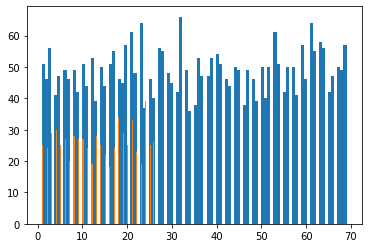

In [262]:
plt.figure()
plt.hist(pball["num"].flatten(), bins=100)
plt.hist(pball["pball"], bins=100)
plt.show()

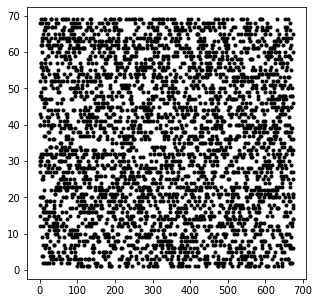

In [263]:
plt.figure(figsize=(5, 5))
# colors = ['r', 'g', 'b', 'c', 'm']
colors = ["k"]*5
for i in range(len(pball["num"])):
    plt.plot(np.ones((5,)).astype(int)*i, pball["num"][i, :], '-o', linewidth=0.0, markersize=3, c=colors[i%len(colors)])
plt.show()

# generate training data

- powerball: 1-69 numbers x5, 1-26 number x1 => 95
- input: (seq. length, batch, feature dim)
- output: (batch, 95)

(675, 6) (675, 6)


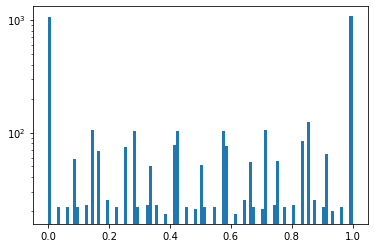

In [268]:
seq_length = len(pball["y"])
inputs = []
outputs = []

for i in range(seq_length):
    num = pball["num"][i]
    num_pball = pball["pball"][i]
    output = list(num)
    output.append(num_pball)
    outputs.append(output)

    year = pball["y"][i]
    month = pball["m"][i]
    day = pball["d"][i]
    
    # min-max normalize [0, 1]
    y = (year-2015) / (2022-2015)
    m = (month) / 12
    d = (day) / 31
    
    flag_y = float((year % 2) == 0)
    flag_m = float((month & 2) == 0)
    flag_d = float((day & 2) == 0)

    inputs.append([y, m, d, flag_y, flag_m, flag_d])
    
inputs = np.float32(inputs)
outputs = np.float32(outputs)
print(inputs.shape, outputs.shape)

plt.figure()
plt.hist(inputs.flatten(), bins=100)
plt.yscale("log")
plt.show()


In [290]:
def one_hot_encode(y, num_classes):
    # y: (seq_length, num_classes)
    seq_length = y.shape[0]
    ys = np.zeros((seq_length, num_classes)).astype(np.float32)
    for s in range(seq_length):
        for c in range(len(y[s])):
            ys[s, int(y[s, c])-1] = 1.0
    return ys

class PowerballDataset(torch.utils.data.Dataset):
    def __init__(self, x, y_num, y_pball):
        self.x = x
        self.y_num = y_num
        self.y_pball = y_pball

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y_num[i], self.y_pball[i]
n_tr = int(seq_length * 0.9)
n_te = seq_length - n_tr

in_tr = torch.Tensor(inputs[0:n_tr, :][:, None, :])
in_te = torch.Tensor(inputs[n_tr:, :][:, None, :])

outputs_num = one_hot_encode(outputs[:, 0:5], 69)
outputs_pball = one_hot_encode(outputs[:, 5][:, None], 26)
print("encoded outputs:", outputs_num.shape, outputs_pball.shape)

# sanity check
for s in range(seq_length):
    for i in range(69):
        v = int(outputs_num[s, i])
        if v == 1:
            if not (i+1 in outputs[s, 0:5].astype(int)):
                assert (i+1 in outputs[s, 0:5].astype(int))
    for i in range(26):
        v = int(outputs_pball[s, i])
        if v == 1:
            assert(i+1 == int(outputs[s, 5]))
outputs_num = torch.Tensor(outputs_num)
out_num_tr = outputs_num[0:n_tr, :]
out_num_te = outputs_num[n_tr:, :]

outputs_pball = torch.Tensor(outputs_pball)
out_pball_tr = outputs_pball[0:n_tr, :]
out_pball_te = outputs_pball[n_tr:, :]
print("train:")
print("\tinput:", in_tr.shape)
print("\toutput: num={}, pball={}".format(out_num_tr.shape, out_pball_tr.shape))
print("test:")
print("\tinput:", in_te.shape)
print("\toutput: num={}, pball={}".format(out_num_te.shape, out_pball_te.shape))

sub_seq_length = 100
in_tr_batch = None
out_num_tr_batch = None
out_pball_tr_batch = None
for i in range(len(in_tr)):
    i1 = i
    i2 = i1 + sub_seq_length
    if i2 > len(in_tr):
        break
    in_slice = in_tr[i1:i2, :, :]
    out_num_slice = out_num_tr[i1:i2, :][:, None, :]
    out_pball_slice = out_pball_tr[i1:i2, :][:, None, :]
    if in_tr_batch is None:
        in_tr_batch = in_slice
        out_num_tr_batch = out_num_slice
        out_pball_tr_batch = out_pball_slice
    else:
        in_tr_batch = torch.cat([in_tr_batch, in_slice], dim=1)
        out_num_tr_batch = torch.cat([out_num_tr_batch, out_num_slice], dim=1)
        out_pball_tr_batch = torch.cat([out_pball_tr_batch, out_pball_slice], dim=1)
in_tr_batch = in_tr_batch.transpose(0, 1)
out_num_tr_batch = out_num_tr_batch.transpose(0, 1)
out_pball_tr_batch = out_pball_tr_batch.transpose(0, 1)
print("batched: {}, {}, {}".format(in_tr_batch.shape, out_num_tr_batch.shape, out_pball_tr_batch.shape))
powerball_dataset = PowerballDataset(x=in_tr_batch, y_num=out_num_tr_batch, y_pball=out_pball_tr_batch)

batch_size = 10
data_generator = torch.utils.data.DataLoader(powerball_dataset, batch_size=batch_size, shuffle=True)

x, y_num, y_pball = powerball_dataset[0]
print(x.shape, y_num.shape, y_pball.shape)
n_batch = len(powerball_dataset)
print("n_batch =", n_batch)
print(len(data_generator))
for x_batch, y_num_batch, y_pball_batch in data_generator:
    print(x_batch.shape, y_num_batch.shape, y_pball_batch.shape)
    break

encoded outputs: (675, 69) (675, 26)
train:
	input: torch.Size([607, 1, 6])
	output: num=torch.Size([607, 69]), pball=torch.Size([607, 26])
test:
	input: torch.Size([68, 1, 6])
	output: num=torch.Size([68, 69]), pball=torch.Size([68, 26])
batched: torch.Size([508, 100, 6]), torch.Size([508, 100, 69]), torch.Size([508, 100, 26])
torch.Size([100, 6]) torch.Size([100, 69]) torch.Size([100, 26])
n_batch = 508
51
torch.Size([10, 100, 6]) torch.Size([10, 100, 69]) torch.Size([10, 100, 26])


# model

In [329]:
import torch
from torch.autograd import Variable

class PowerballLSTM(torch.nn.Module):
    def __init__(self, number_dim, powerball_dim, input_size, hidden_size, num_layers, seq_length):
        super(PowerballLSTM, self).__init__()
        self.number_dim = number_dim
        self.powerball_dim = powerball_dim
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = torch.nn.Linear(hidden_size, hidden_size//2)
        self.fc_num = torch.nn.Linear(hidden_size//2, number_dim)
        self.fc_pball = torch.nn.Linear(hidden_size//2, powerball_dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x):
        batch_size = x.shape[0]
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size) # hidden state
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size) # internal state
        
        # propagate through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.relu(output)
        out = self.fc1(out)
        out = self.relu(out)
        
        out_num = self.softmax(self.fc_num(out))
        out_powerball = self.sigmoid(self.fc_pball(out))
        return out_num, out_powerball


Loss: 2.39830:   0%|                        | 100/20000 [00:19<07:44, 42.83it/s]

In [345]:
num_epochs = 1000 # epochs
learning_rate = 0.01 #0.001 lr
input_size = in_tr_batch.shape[-1] # number of features
hidden_size = 128 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

print("batch_size", batch_size)
# number of output classes 
num_dim = 69
powerball_dim = 26

model = PowerballLSTM(num_dim, powerball_dim, input_size, hidden_size, num_layers, seq_length) # our lstm class 

BCELoss = torch.nn.BCELoss()
BCELossMultiLabel = torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[600, 10000], gamma=0.5)
for name in model.named_parameters():
    print(name[0], " -> ", name[1].shape)


batch_size 10
lstm.weight_ih_l0  ->  torch.Size([512, 6])
lstm.weight_hh_l0  ->  torch.Size([512, 128])
lstm.bias_ih_l0  ->  torch.Size([512])
lstm.bias_hh_l0  ->  torch.Size([512])
fc1.weight  ->  torch.Size([64, 128])
fc1.bias  ->  torch.Size([64])
fc_num.weight  ->  torch.Size([69, 64])
fc_num.bias  ->  torch.Size([69])
fc_pball.weight  ->  torch.Size([26, 64])
fc_pball.bias  ->  torch.Size([26])


In [348]:
losses = []

save_dir = os.path.join("outputs/models/")
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "model.pt")
pbar = tqdm.tqdm(total=num_epochs, file=sys.stdout)
for epoch in range(num_epochs):
    loss_batch = 0
    for x_batch, y_num_batch, y_pball_batch in data_generator:

        # forward pass
        pred_num, pred_pball = model(x_batch)
        
        optimizer.zero_grad()
        l_pball = BCELoss(pred_pball, y_pball_batch)
        l_num = BCELossMultiLabel(pred_num, y_num_batch)
        loss = l_pball + l_num
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_batch += loss.item()
    losses.append(loss_batch / batch_size)
#     if epoch % 100 == 0:
    pbar.set_description('Loss: {:.5f}'.format(losses[-1]))
    pbar.update(1)
    
    # save model
    if epoch % 100 == 0:
        torch.save(model.state_dict(), save_path)
        print("model saved:", save_path)
pbar.close()



Loss: 2.05886:   1%|▎                       | 14/1000 [03:08<3:41:18, 13.47s/it]


/var/folders/5y/3hp5p1p51tq7bccf9gqccrsc0000gn/T/ipykernel_63476/1838887051.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out_num = self.softmax(self.fc_num(out))



Loss: 2.04123:   0%|                           | 1/1000 [00:02<37:35,  2.26s/it]model saved: outputs/models/model.pt

Loss: 1.39618:   5%|█▏                        | 48/1000 [01:51<36:05,  2.27s/it]


Loss: 0.81367:  10%|██▌                       | 97/1000 [03:40<33:47,  2.25s/it]


Loss: 0.79727:  10%|██▌                      | 101/1000 [03:49<33:51,  2.26s/it]model saved: outputs/models/model.pt

Loss: 0.69803:  14%|███▌                     | 145/1000 [05:35<33:18,  2.34s/it]


Loss: 0.63372:  19%|████▊                    | 194/1000 [07:27<31:05,  2.31s/it]


Loss: 0.63027:  20%|█████                    | 201/1000 [07:43<31:57,  2.40s/it]model saved: outputs/models/model.pt

Loss: 0.61101:  24%|██████                   | 242/1000 [09:20<28:23,  2.25s/it]


Loss: 0.59574:  29%|███████▎                 | 291/1000 [11:12<26:58,  2.28s/it]


Loss: 0.59349:  30%|███████▌                 | 301/1000 [11:35<26:28,  2.27s/it]model saved: outputs/models/model.pt

Loss: 0.58443:  34%|████████▍                | 339/1000 [13:03<24:49,  2.25s/it]


Loss: 0.57498:  39%|█████████▋               | 388/1000 [14:50<22:58,  2.25s/it]


Loss: 0.57382:  40%|██████████               | 401/1000 [15:19<22:21,  2.24s/it]model saved: outputs/models/model.pt

Loss: 0.56925:  44%|██████████▉              | 436/1000 [16:39<21:00,  2.23s/it]


Loss: 0.56191:  48%|████████████▏            | 485/1000 [18:27<19:11,  2.24s/it]


Loss: 0.56201:  50%|████████████▌            | 501/1000 [19:02<18:18,  2.20s/it]model saved: outputs/models/model.pt

Loss: 0.55687:  53%|█████████████▎           | 533/1000 [20:15<17:03,  2.19s/it]


Loss: 0.55294:  58%|██████████████▌          | 582/1000 [22:00<15:18,  2.20s/it]


Loss: 0.55206:  60%|███████████████          | 601/1000 [22:42<14:36,  2.20s/it]model saved: outputs/models/model.pt

Loss: 0.55072:  63%|███████████████▊         | 630/1000 [23:48<13:33,  2.20s/it]


Loss: 0.54541:  68%|████████████████▉        | 679/1000 [25:34<11:45,  2.20s/it]


Loss: 0.54183:  70%|█████████████████▌       | 701/1000 [26:22<10:55,  2.19s/it]model saved: outputs/models/model.pt

Loss: 0.55278:  73%|██████████████████▏      | 727/1000 [27:22<10:12,  2.24s/it]


Loss: 0.54106:  78%|███████████████████▍     | 776/1000 [29:09<08:26,  2.26s/it]


Loss: 0.55831:  80%|████████████████████     | 801/1000 [30:05<07:25,  2.24s/it]model saved: outputs/models/model.pt

Loss: 0.54365:  82%|████████████████████▌    | 824/1000 [30:59<06:34,  2.24s/it]


Loss: 0.53547:  87%|█████████████████████▊   | 873/1000 [32:47<04:44,  2.24s/it]


Loss: 0.53295:  90%|██████████████████████▌  | 901/1000 [33:49<03:41,  2.24s/it]model saved: outputs/models/model.pt

Loss: 0.53647:  92%|███████████████████████  | 921/1000 [34:36<02:56,  2.23s/it]


Loss: 0.53459:  97%|████████████████████████▎| 970/1000 [36:24<01:07,  2.24s/it]


Loss: 0.53413: 100%|████████████████████████| 1000/1000 [37:31<00:00,  2.25s/it]


In [ ]:
plt.figure()
plt.plot(losses)
plt.title("{:.6f}".format(losses[-1]))
plt.show()

In [213]:
def probs2integers(prob, is_pred=True):
    top_fives = []
    seq_length = prob.shape[0]
    
    if is_pred:
        """
        prob = [seq_length, 69]
        """
        indices = np.argsort(prob, axis=1)
        for i in range(seq_length):
            v = []
            idx = indices[i, :]
            for j in range(69-5, 69):
                v.append(idx[j]+1)
            top_fives.append(v)
    else:
        """
        prob = [seq_length, 69]
        """
        for i in range(seq_length):
            v = []
            for j in range(prob.shape[1]):
                if int(prob[i, j]) == 1:
                    v.append(j+1)
            top_fives.append(v)
    top_fives = np.array(top_fives).astype(int)
    return top_fives

def predict(model, x_in):
    model.eval()
    pred_num, pred_pball = model(x_in)
    pred_num = pred_num.detach().numpy()
    pball_pred = np.argmax(pred_pball.detach().numpy(), axis=1) + 1
    
    indices = np.argsort(pred_num, axis=1)
    top_fives = probs2integers(pred_num, is_pred=True)
    return top_fives, pball_pred

pball_gt = np.argmax(out_pball_tr.numpy().astype(int), axis=1) + 1
in_tr_te = torch.cat([in_tr, in_te])

num_pred, pball_pred = predict(model, in_tr_te[0:200, :, :])
seq_length = num_pred.shape[0]


/var/folders/5y/3hp5p1p51tq7bccf9gqccrsc0000gn/T/ipykernel_63476/802393720.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out_num = self.softmax(self.fc_num(out))


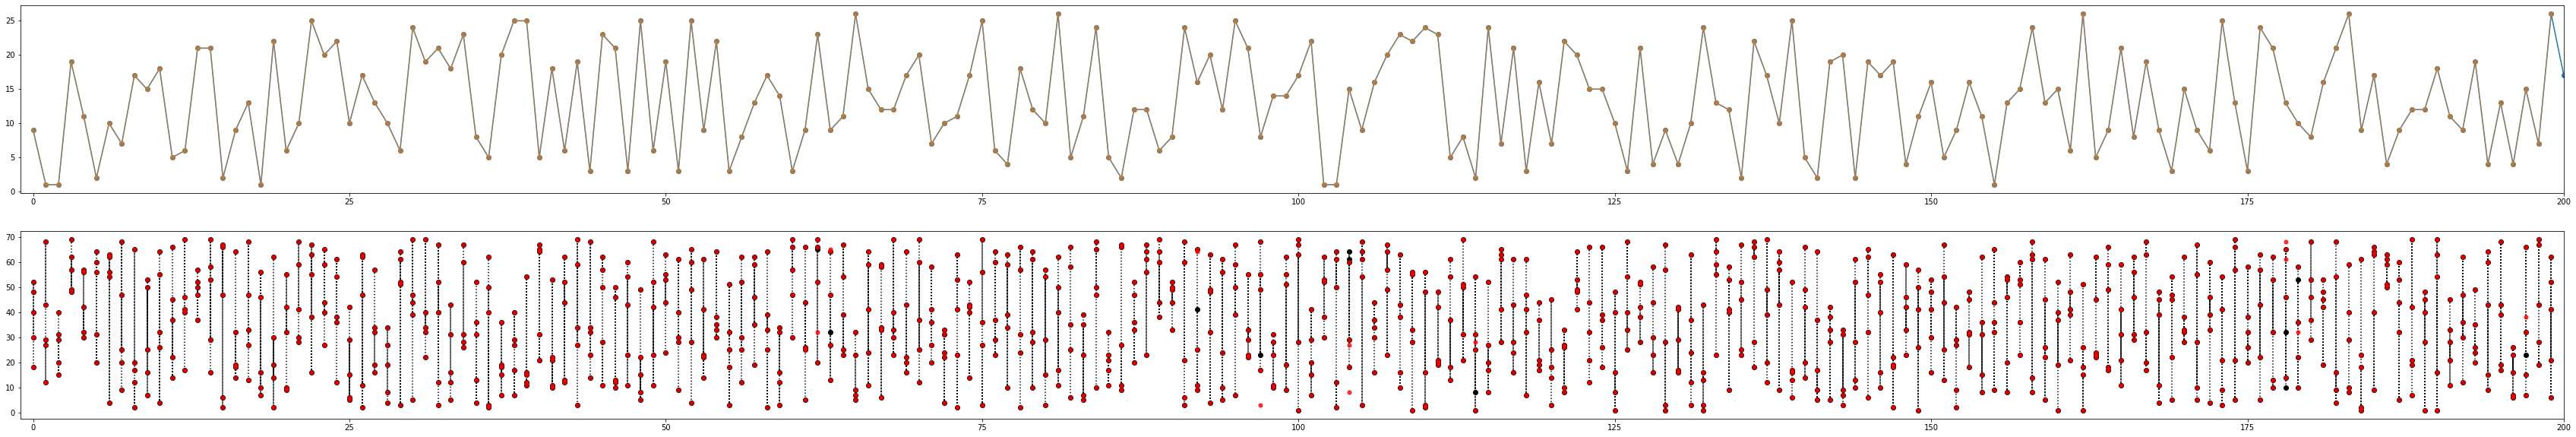

In [214]:

fig = plt.figure(figsize=(60, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

pball_gts = np.argmax(outputs_pball.numpy(), axis=1) + 1
ax1.plot(pball_gts, "-o")
ax1.plot(pball_pred, "-o", alpha=0.5)

colors = ['k']
out_num_ints = probs2integers(outputs_num.numpy(), is_pred=False)
for s in range(seq_length):
    nums = num_pred[s, :]
    nums_gt = out_num_ints[s, :]
    ax2.plot(np.ones((5,))*s, nums, ':o', c=colors[s%len(colors)])
    ax2.plot(np.ones((5,))*s, nums_gt, 'o', c='r', markersize=5, alpha=0.8)

ax1.set_xlim([-1, seq_length])
ax2.set_xlim([-1, seq_length])
plt.show()


In [215]:
def predict_numbers(model, year, month, day):
    model.eval()
    
    y = (float(year)-2015)/(2022-2015)
    m = float(month)/12
    d = float(day)/31
    fy = float((year % 2) == 0)
    fm = float((month % 2) == 0)
    fd = float((day % 2) == 0)
    x_in = torch.Tensor([y, m, d, fy, fm, fd])[None, None, :]
    pred_num, pred_pball = model(x_in)
    pball_pred = np.argmax(pred_pball.detach().numpy(), axis=1) + 1
    top_fives = probs2integers(pred_num.detach().numpy(), is_pred=True)
    return top_fives, pball_pred

for s in range(len(pball["y"])):
    year = pball["y"][s]
    month = pball["m"][s]
    day = pball["d"][s]
    
    num_p = np.sort(num_pred[s, :])
    num_gt = np.sort(out_num_ints[s, :])
    pball_p = pball_pred[s]
    pball_gt = pball_gts[s]
    
    n_correct = 0
    for f in num_p:
        if f in num_gt:
            n_correct += 1
    print("{}-{}-{} | gt:{} pred:{} correct={}/{} \t| gt:{} pred:{} correct={}".format(year, month, day, num_gt, num_p.flatten(), n_correct, len(num_gt), pball_gt, pball_p, pball_gt == pball_p))


2015-10-7 | gt:[18 30 40 48 52] pred:[18 30 40 48 52] correct=5/5 	| gt:9 pred:9 correct=True
2015-10-10 | gt:[12 27 29 43 68] pred:[12 27 29 43 68] correct=5/5 	| gt:1 pred:1 correct=True
2015-10-14 | gt:[15 20 29 31 40] pred:[15 20 29 31 40] correct=5/5 	| gt:1 pred:1 correct=True
2015-10-17 | gt:[48 49 57 62 69] pred:[48 49 57 62 69] correct=5/5 	| gt:19 pred:19 correct=True
2015-10-21 | gt:[30 32 42 56 57] pred:[30 32 42 56 57] correct=5/5 	| gt:11 pred:11 correct=True
2015-10-24 | gt:[20 31 56 60 64] pred:[20 31 56 60 64] correct=5/5 	| gt:2 pred:2 correct=True
2015-10-28 | gt:[ 4 54 56 62 63] pred:[ 4 54 56 62 63] correct=5/5 	| gt:10 pred:10 correct=True
2015-10-31 | gt:[ 9 20 25 47 68] pred:[ 9 20 25 47 68] correct=5/5 	| gt:7 pred:7 correct=True
2015-11-4 | gt:[ 2 12 17 20 65] pred:[ 2 12 17 20 65] correct=5/5 	| gt:17 pred:17 correct=True
2015-11-7 | gt:[ 7 16 25 50 53] pred:[ 7 16 25 50 53] correct=5/5 	| gt:15 pred:15 correct=True
2015-11-11 | gt:[ 4 26 32 55 64] pred:[ 4 2

IndexError: index 200 is out of bounds for axis 0 with size 200